<a href="https://colab.research.google.com/github/khinkhinkhant112316/Code-Lab-channel/blob/main/test4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Import libraries
import warnings
warnings.simplefilter(action='ignore')
import os
import zipfile
from shutil import copyfile
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load and extract the dataset
input_path = "/content/drive/MyDrive/Plant_Village_Dataset_Corn/CORN_L~1.ZIP"

local_zip = input_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Plant_Village_Dataset_Corn')
zip_ref.close()

In [ ]:
extrac_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/'

for set_ in ['Corn_Leaf_Disease']:
    n_blight = len(os.listdir(extrac_path+set_ + '/Blight'))
    n_common_rust = len(os.listdir(extrac_path+set_ + '/Common_Rust'))
    n_gray_leaf_spot = len(os.listdir(extrac_path+set_ + '/Gray_Leaf_Spot'))
    n_health = len(os.listdir(extrac_path+set_ + '/Healthy'))
    print('blight images: {}, common rust images: {}, gray leaf spot images: {}, healt images:{}'.format(n_blight,
                                                                                                         n_common_rust,
                                                                                                         n_gray_leaf_spot,
                                                                                                         n_health))

blight images: 1, common rust images: 1, gray leaf spot images: 1, healt images:1


In [ ]:
##Create train and test files
try:
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Healthy')
except OSError:
    print(file)

NameError: name 'file' is not defined

In [ ]:
import os

try:
    # Creating directories for training data
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Healthy')

    # Creating directories for validation data
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Healthy')

    # Creating directories for testing data
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Healthy')
except OSError as e:
    print("Creation of directories failed:", e)


In [33]:
#Split and assign the data into train and test files(80:20)
def split_data(SOURCE, TRAINING, VALIDATION, TESTING):

    all_files = []

    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point_1 = round(n_files * 0.8)
    split_point_2 = round(n_files * 0.9)

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point_1]
    val_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]

    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)

    for file_name in val_set:
        copyfile(SOURCE + file_name, VALIDATION + file_name)

    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

Blight_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Blight/Corn___Northern_Leaf_Blight/'
Common_Rust_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Common_Rust/Corn___Common_rust/'
Gray_Leaf_Spot_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Gray_Leaf_Spot/Corn___Cercospora_leaf_spot Gray_leaf_spot/'
Healthy_SOURCE_DIR = '//content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Healthy/Corn___healthy/'

TRAINING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Blight/'
TRAINING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Common_Rust/'
TRAINING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Gray_Leaf_Spot/'
TRAINING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Healthy/'

VALIDATION_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Blight/'
VALIDATION_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Common_Rust/'
VALIDATION_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Gray_Leaf_Spot/'
VALIDATION_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Healthy/'

TESTING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Blight/'
TESTING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Common_Rust/'
TESTING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Gray_Leaf_Spot/'
TESTING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Healthy/'


split_data(Blight_SOURCE_DIR, TRAINING_Blight_DIR, VALIDATION_Blight_DIR, TESTING_Blight_DIR)
split_data(Common_Rust_SOURCE_DIR, TRAINING_Common_Rust_DIR, VALIDATION_Common_Rust_DIR, TESTING_Common_Rust_DIR)
split_data(Gray_Leaf_Spot_SOURCE_DIR,TRAINING_Gray_Leaf_Spot_DIR, VALIDATION_Gray_Leaf_Spot_DIR, TESTING_Gray_Leaf_Spot_DIR)
split_data(Healthy_SOURCE_DIR,TRAINING_Healthy_DIR, VALIDATION_Healthy_DIR, TESTING_Healthy_DIR)

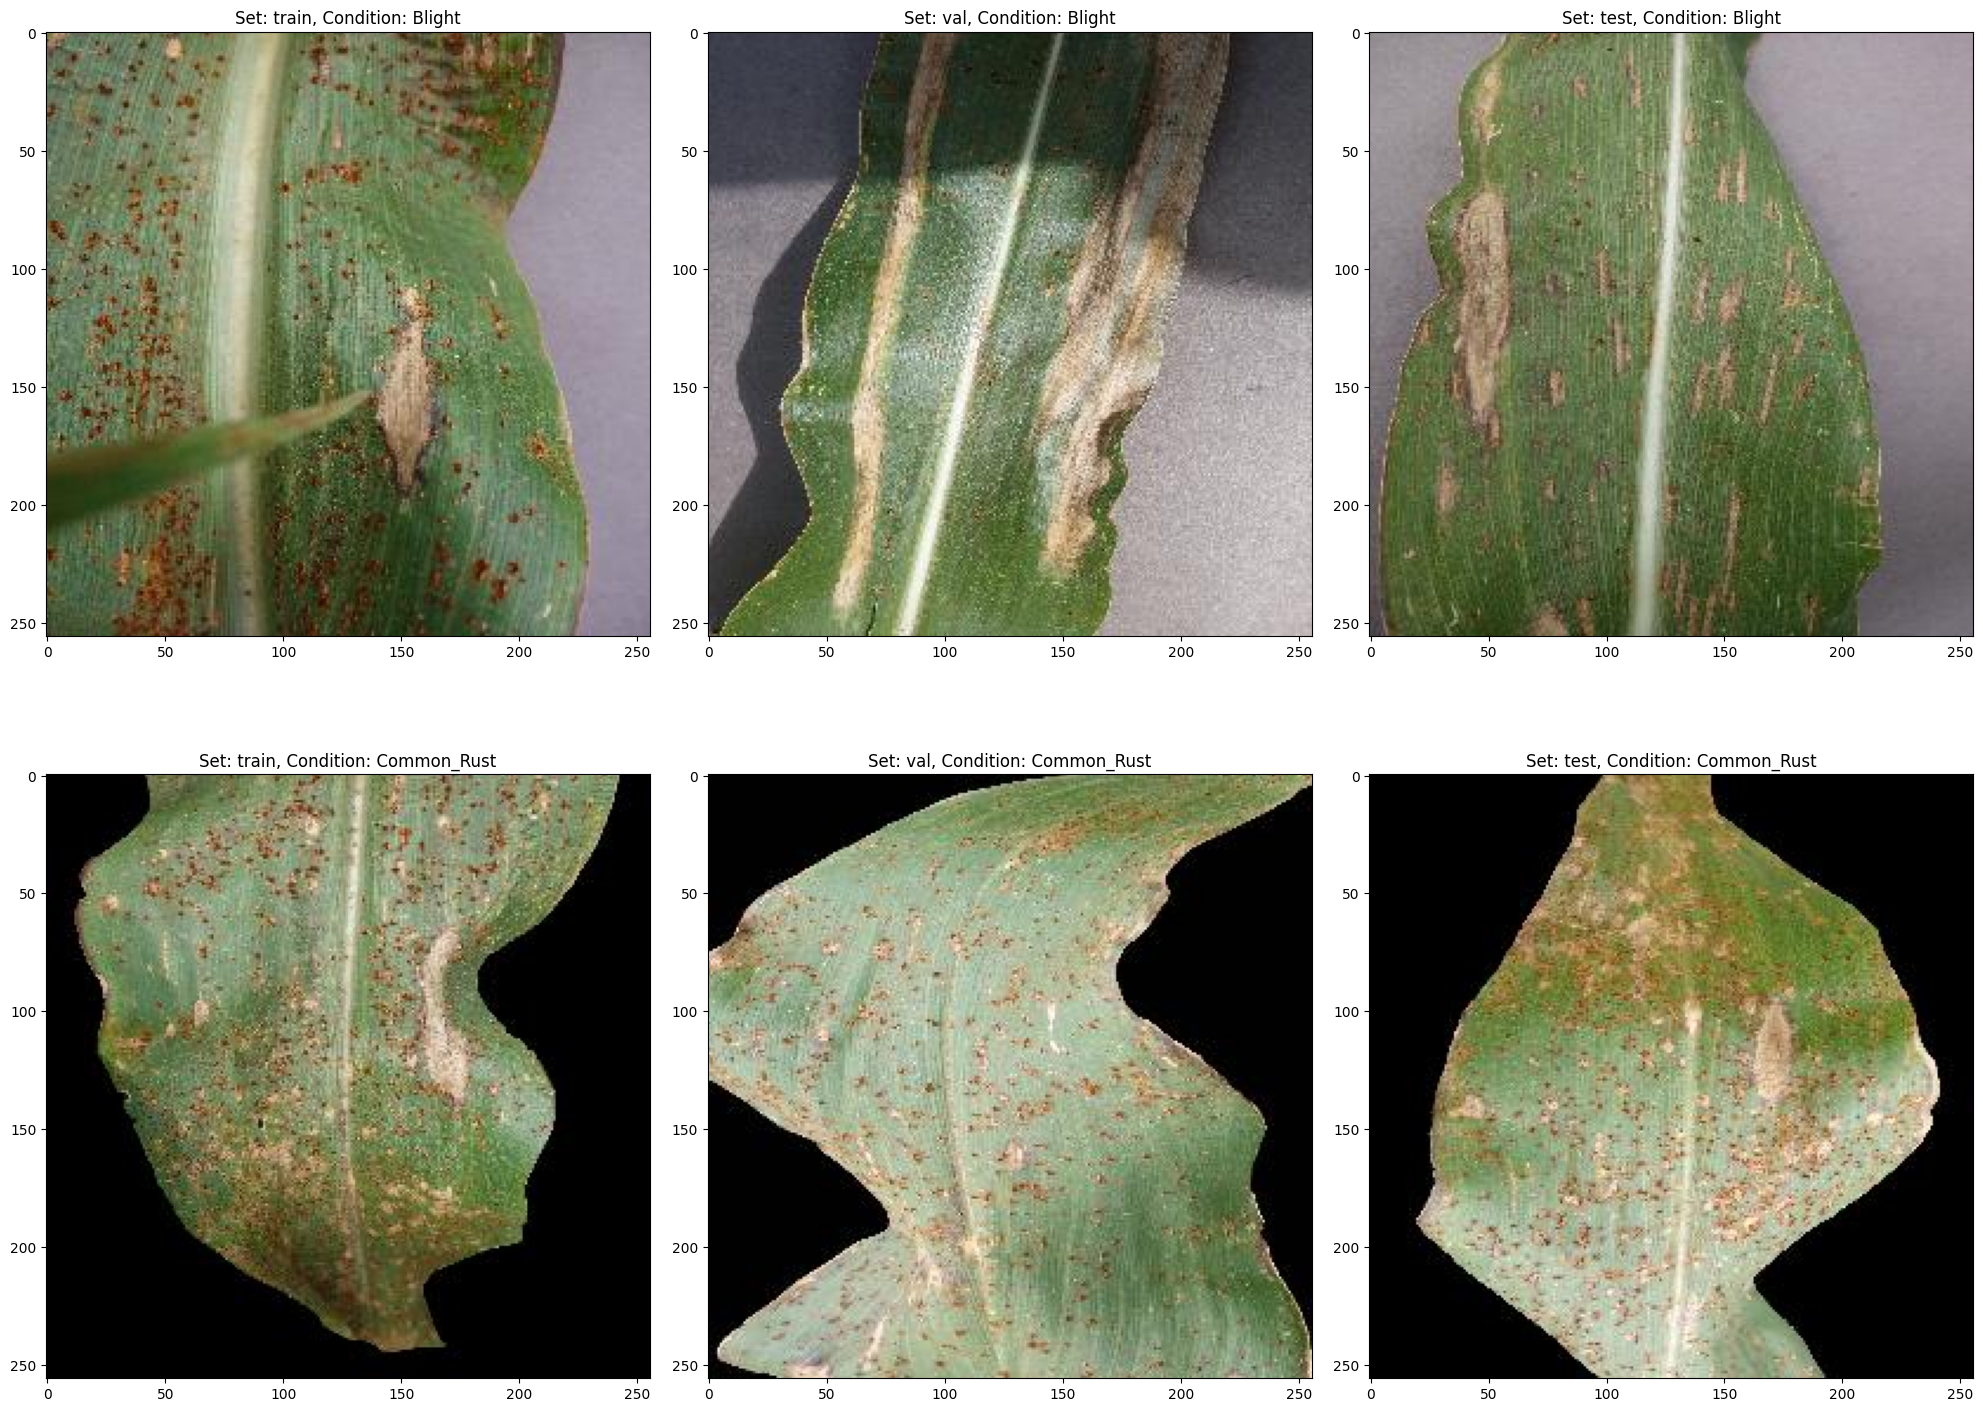

In [34]:
##
path_ = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/'

fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val', 'test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Blight/'+os.listdir(set_path+'/Blight')[0]))
    ax[i].set_title('Set: {}, Condition: Blight'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Common_Rust/'+os.listdir(set_path+'/Common_Rust')[0]))
    ax[i+3].set_title('Set: {}, Condition: Common_Rust'.format(set_))

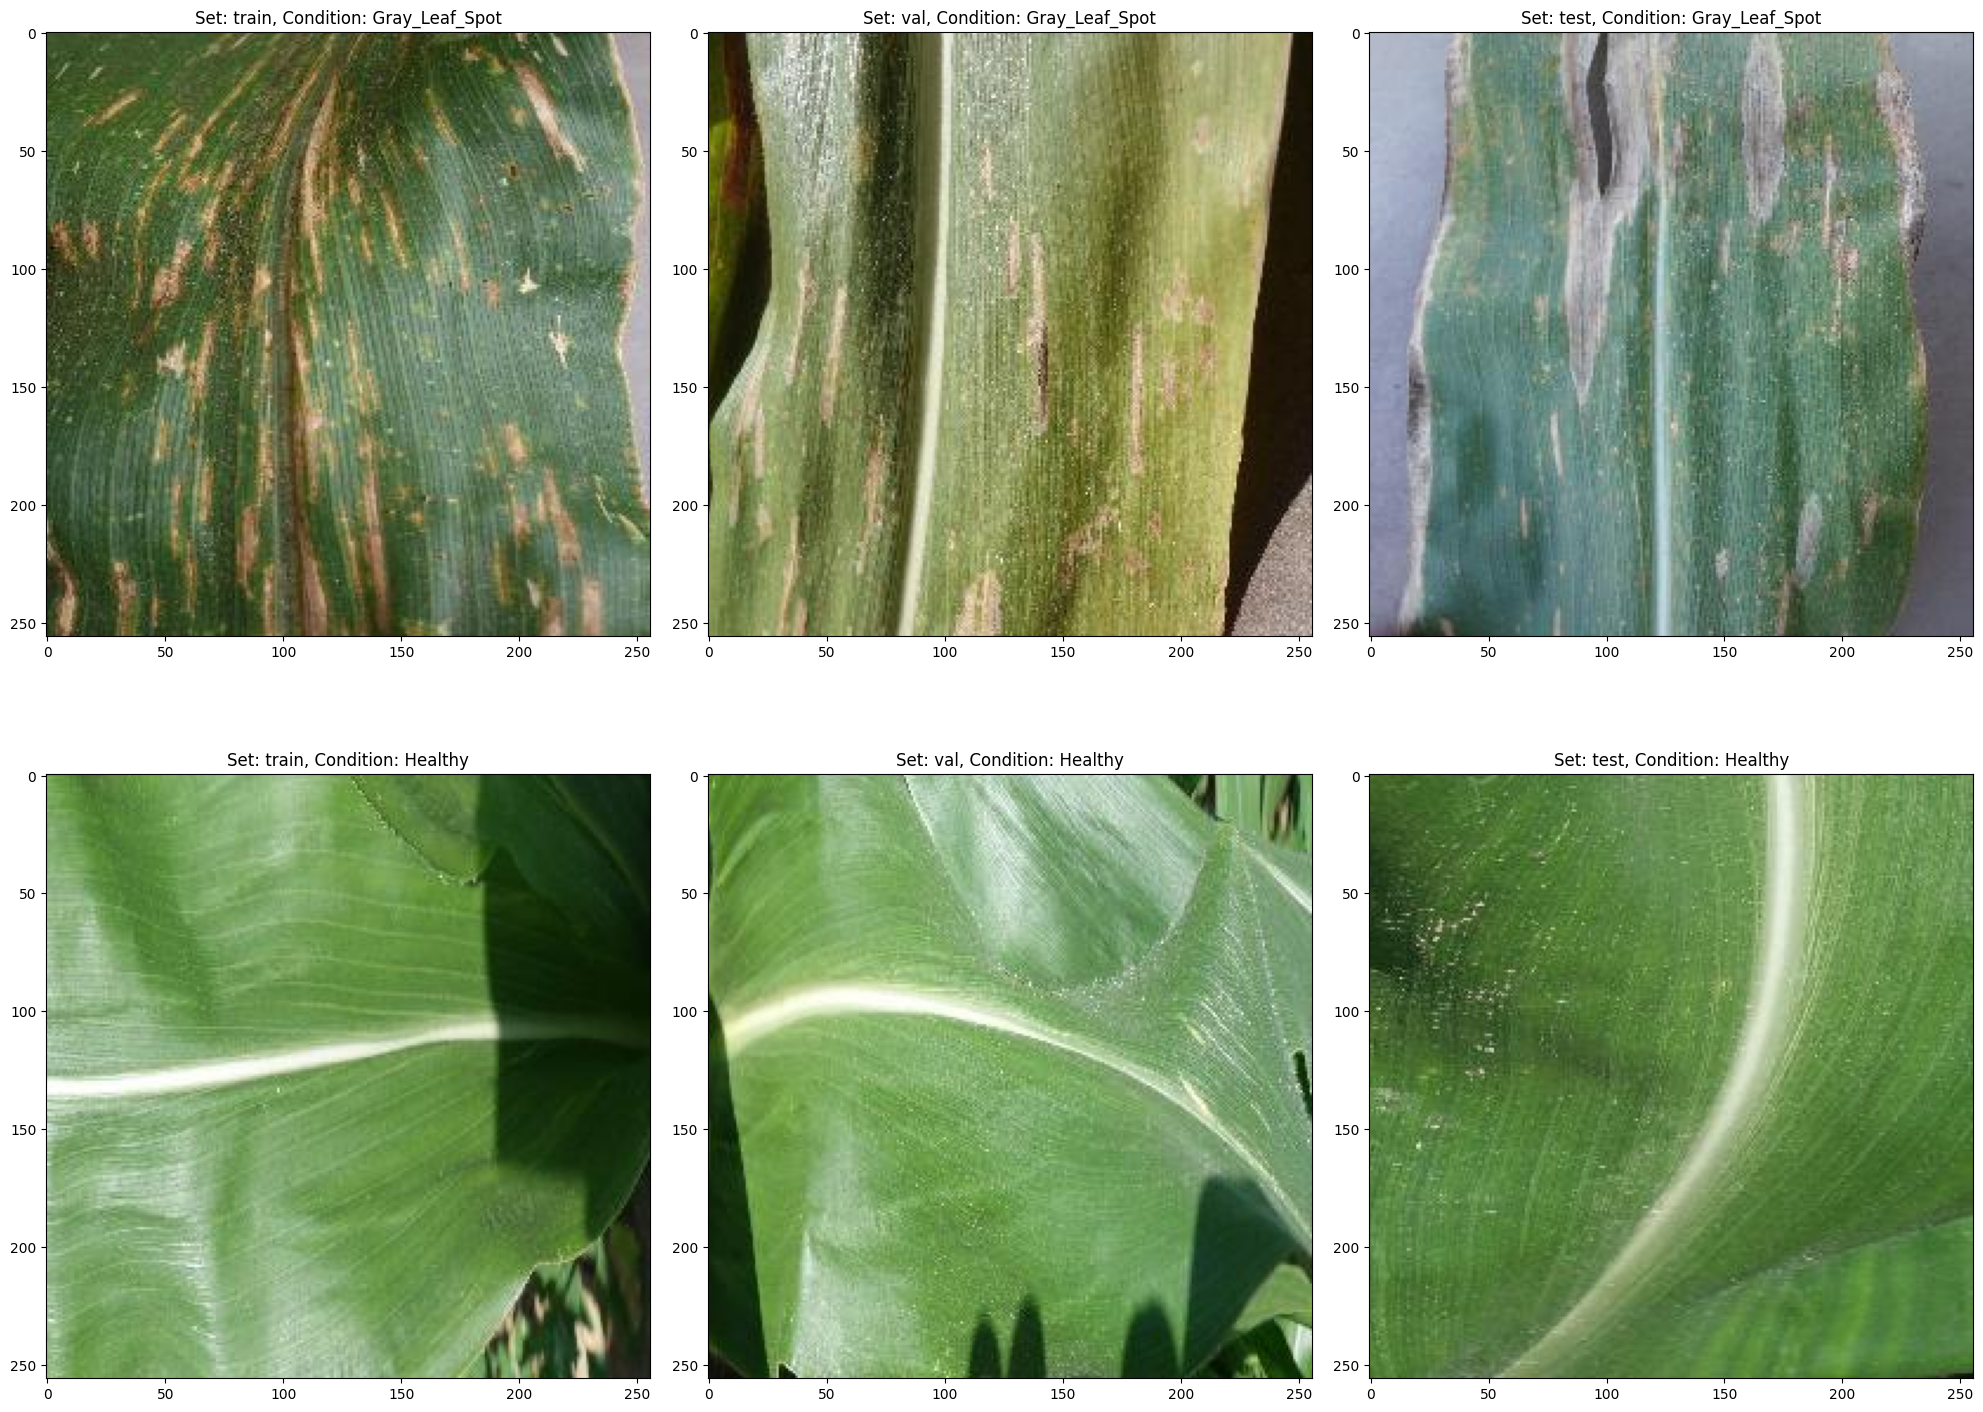

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val','test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Gray_Leaf_Spot/'+os.listdir(set_path+'/Gray_Leaf_Spot')[0]))
    ax[i].set_title('Set: {}, Condition: Gray_Leaf_Spot'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Healthy/'+os.listdir(set_path+'/Healthy')[0]))
    ax[i+3].set_title('Set: {}, Condition: Healthy'.format(set_))

In [35]:
def train_val_test_data(img_dims, batch_size):

  ## Training data
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 40,
                                       width_shift_range = .2,
                                       height_shift_range = .2,
                                       shear_range = .2,
                                       zoom_range = 0.3,
                                       horizontal_flip = True,
                                       vertical_flip=True,
                                       brightness_range=[0.5, 1.5],
                                       featurewise_center=True,
                                       featurewise_std_normalization=True,
                                       fill_mode = 'nearest',
                                   )


  ## Train generator
  train_gen = train_datagen.flow_from_directory(directory = path_ + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = True)
  ## Validation Data

  validation_datagen = ImageDataGenerator(rescale = 1./255)
  ## validation generator

  val_gen = validation_datagen.flow_from_directory(directory = path_ + 'val',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical',
                                                      shuffle = True)



  return train_gen, val_gen

In [36]:
img_dims = 224
batch_size = 128

train_gen, val_gen = train_val_test_data(img_dims, batch_size)

Found 3637 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.


In [39]:
## Choose a device type (CPU or GPU)
devices = tf.config.list_physical_devices('CPU')
print(devices[0])

## Name divice
name_cpu = "CPU:0"

## Define my strategy like One Device Strategy
strategy = tf.distribute.OneDeviceStrategy(device=name_cpu)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [40]:
def mobilenetv2():

  mobilenet_m = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_dims,img_dims,3),
                                                               include_top = False,
                                                               weights = 'imagenet'
                                                               )
  x = mobilenet_m.trainable = False
  x = mobilenet_m.output

  x = GlobalAveragePooling2D()(x)
  out = Dense(4,activation='softmax')(x)

  model = Model(inputs = mobilenet_m.inputs, outputs = out)

  model.summary()

  return model

In [41]:
with strategy.scope():

  mobilenetv2_model = mobilenetv2()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = .0001),metrics = ['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [43]:
epochs_1 = 2
history_1 = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                               epochs=epochs_1, validation_data=(val_gen),
                               validation_steps=val_gen.samples // batch_size
                                    )

Epoch 1/2
28/28 [==============================] - 181s 6s/step - loss: 0.2686 - accuracy: 0.8983 - val_loss: 0.2627 - val_accuracy: 0.9023
Epoch 2/2
28/28 [==============================] - 181s 6s/step - loss: 0.2325 - accuracy: 0.9137 - val_loss: 0.2188 - val_accuracy: 0.9160
